In [1]:
import sys

import json
import metal
import os
# Import other dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('/dfs/scratch0/zzweng/metal/metal/mmtl/birds')
os.environ['METALHOME'] = '/dfs/scratch0/zzweng/metal/'
# Set random seed for notebook
SEED = 123

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from skimage import io, transform
import torchvision.transforms as transforms
import numpy as np
from PIL import Image, ImageDraw
DATASET_DIR = '/dfs/scratch0/chami/maskrcnn-benchmark/datasets/traffic_light_data/'
IMAGES_DIR = os.path.join(DATASET_DIR, 'frames')
save_dir = '/dfs/scratch0/chami/maskrcnn-benchmark/datasets/traffic_light_data/annotations/'
tt = transforms.ToTensor()

### Create train/val/test dataset

We want to create a dataset with train/test/val splits such that:
- label =  1 if there is a red traffic light or yellow traffic light
- label = 0 if there is not traffic light or green traffic light

In [4]:
import torch.utils.data as data

splits = {
    'train': ['dayClip1', 'dayClip5', 'dayClip6', 'dayClip7', 
              'dayClip8', 'dayClip9', 'dayClip10', 'dayClip11', 
              'dayClip12', 'dayClip13', 'nightClip2',
              'nightClip3', 'nightClip4', 'nightClip5'],
    'val' : ['dayClip4'],
    'test': ['dayClip2', 'dayClip3', 'nightClip1'],
    'test_night': ['nightClip1'],
    'test_day': ['dayClip2', 'dayClip3'],
}  # not used in this notebook

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


class Dataset(data.Dataset):
    def __init__(self, split):        
        with open(os.path.join(save_dir, f'{split}.json')) as f:
            annotations = json.load(f)['annotations']
        self.filenames = {}
        self.labels = {}
        self.bbox = {}
        for a in annotations:
            img_id = a['image_id']
            self.filenames[img_id] = a['filename']
            self.labels[img_id] = int(a['tag'] in ['stop', 'warning'])  # label = 1 if red(stop) or yellow(warning)
            if img_id not in self.bbox:
                self.bbox[img_id] = [a['bbox']]
            else:
                self.bbox[img_id].append(a['bbox'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        idx += 1 # file IDs starts with 1
        fname = self.filenames[idx]
        image_data = io.imread(os.path.join(IMAGES_DIR, fname))
        image_data = transform.resize(image_data, (224,224,3))  # resize all images to 224x224
        image_data = normalize(tt(image_data).type(torch.float32))
        
        x_dict = {"data": image_data}
        y_dict = {"labelset_gold": torch.Tensor(self.labels[idx])}
        return x_dict, y_dict
    
    def draw(self, idx):
        fname = self.filenames[idx]
        img = Image.open(os.path.join(IMAGES_DIR, fname))
        draw = ImageDraw.Draw(img)
        for (left, bottom, right, top) in self.bbox[idx]:
            draw.rectangle([left, bottom, right, top], outline='red', width=3)
        return img

15752 263 1998


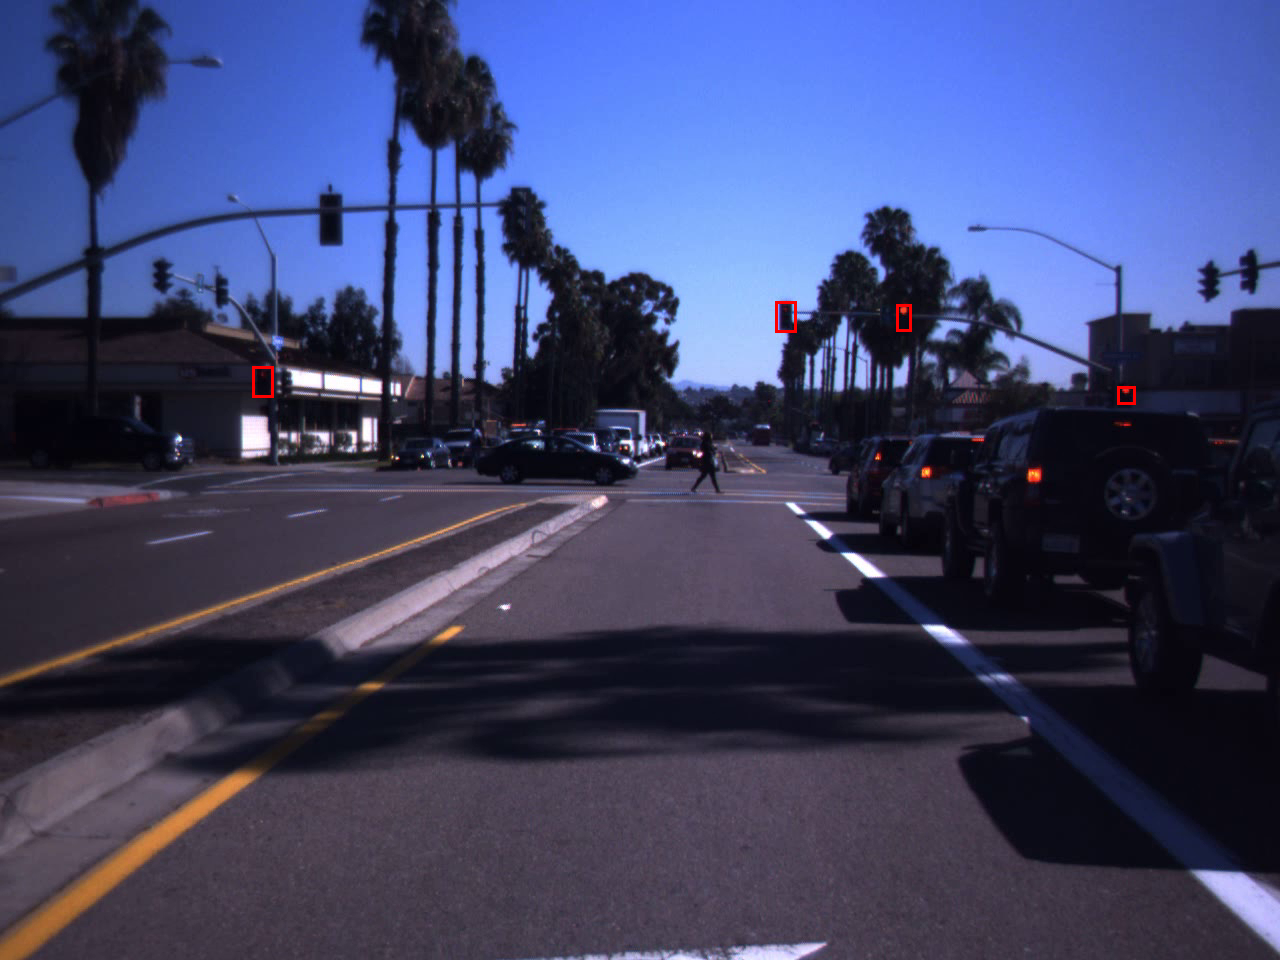

In [9]:
train_data = Dataset('train')
val_data = Dataset('val')
test_data = Dataset('test')
print(len(train_data), len(val_data), len(test_data))
train_data.draw(1)

Create a task. Use a resnet18 for now as our input model.

In [10]:
from metal.mmtl.slicing.tasks import MultiClassificationTask
from metal.mmtl.metal_model import MetalModel 
from resnet import *

resnet_model = resnet18(num_classes=2, use_as_feature_extractor=True).float().cuda()
task_name = 'TrafficLightClassificationTask'
task0 = MultiClassificationTask(
    name=task_name, 
    input_module=resnet_model,
    head_module=resnet_model.fc
)
tasks = [task0]
model = MetalModel(tasks, verbose=False)

Create payload abstraction for our train/valid/test sets.

In [11]:
from metal.mmtl.payload import Payload
from metal.mmtl.data import MmtlDataLoader
from pprint import pprint

dl_kwargs = {
    "batch_size": 8
}
payloads = []
splits = ["train", "val", "test"]
datasets = [train_data, val_data, test_data]
for i, split in enumerate(splits):
    payload_name = f"Payload{i}_{split}"
    labels_to_tasks = {"labelset_gold": task_name}
    if split == 'train':
        payload = Payload(payload_name, MmtlDataLoader(datasets[i], shuffle=True, **dl_kwargs), labels_to_tasks, split)
    else:
        payload = Payload(payload_name, MmtlDataLoader(datasets[i], shuffle=False, **dl_kwargs), labels_to_tasks, split)
    payloads.append(payload)

pprint(payloads)

payload.data_loader

[Payload(Payload0_train: labels_to_tasks=[{'labelset_gold': 'TrafficLightClassificationTask'}], split=train),
 Payload(Payload1_val: labels_to_tasks=[{'labelset_gold': 'TrafficLightClassificationTask'}], split=val),
 Payload(Payload2_test: labels_to_tasks=[{'labelset_gold': 'TrafficLightClassificationTask'}], split=test)]


In [ ]:
from metal.mmtl.trainer import MultitaskTrainer
trainer = MultitaskTrainer()
scores = trainer.train_model(
    model, 
    payloads, 
    n_epochs=1, 
    log_every=2,
    lr=0.001,
    progress_bar=True,
    lr_scheduler='reduce_on_plateau',
    patience = 10,
    checkpoint_every = 1,
    checkpoint_metric='TrafficLightClassificationTask/Payload1_val/labels/accuracy',
    checkpoint_metric_mode='max'
)

CONFIG:  {'verbose': True, 'seed': 91834, 'commit_hash': None, 'ami': None, 'progress_bar': True, 'n_epochs': 1, 'l2': 0.0, 'grad_clip': 1.0, 'optimizer_config': {'optimizer': 'adam', 'optimizer_common': {'lr': 0.001}, 'sgd_config': {'momentum': 0.9}, 'adam_config': {'betas': (0.9, 0.999)}, 'rmsprop_config': {}}, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_config': {'warmup_steps': 0.0, 'warmup_unit': 'epochs', 'min_lr': 1e-06, 'exponential_config': {'gamma': 0.999}, 'plateau_config': {'factor': 0.5, 'patience': 10, 'threshold': 0.0001}}, 'metrics_config': {'task_metrics': [], 'trainer_metrics': ['model/valid/all/loss'], 'aggregate_metric_fns': [], 'max_valid_examples': 0, 'valid_split': 'valid', 'test_split': 'test'}, 'task_scheduler': 'proportional', 'logger': True, 'logger_config': {'log_unit': 'epochs', 'log_every': 2, 'score_every': -1.0, 'log_lr': True}, 'writer': None, 'writer_config': {'log_dir': '/dfs/scratch0/zzweng/metal//logs', 'run_dir': None, 'run_name': None, 'wri

In [ ]:
# model_name = 'resnet18_lr_1e-3_epoch1.pt'
# torch.save(model, model_name)

In [ ]:
# model = torch.load(model_name)
# predictions = torch.tensor(model.predict(payloads[2], task_name=task_name))
# gold_labels = torch.tensor(test_data.labels)

# print((predictions == gold_labels).sum())
# incorrect_predictions = (predictions != gold_labels).nonzero().flatten().tolist()  # get indices of incorrect predictions
# print(len(incorrect_predictions))
